## Libs

In [2]:
# !pip install pandas pyarrow
# !pip install ydata-profiling
# !pip install pandas_visual_analysis

import pandas as pd
import numpy as np
from collections import Counter
from pandas_profiling import ProfileReport
from pandas_visual_analysis import VisualAnalysis


/tmp/ipykernel_56896/633393172.py:8: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [3]:
%matplotlib inline


## Data

In [4]:
historic_ex_df = pd.read_parquet('data/historical_currency_exchange.parquet')
transactions_df = pd.read_parquet('data/transaction_fraud_data.parquet')

### EDA with Historical Exchange 

In [4]:
profile = ProfileReport(historic_ex_df, title="Historic Exchange")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:00<00:00, 114130.72it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
VisualAnalysis(historic_ex_df)

1) Гипотеза - использовать аномалии во временных рядах и кластеры валют по поведению для выявления групп с похожей динамикой, что будет выступать как вспомогательные признаки для детекции и прогназирования фрода 

Используем STL дукомпозицию из-за коротко ряда,а так же устойчивого к выбросам, тк шум (нерегулярные скачки) часто бывает в рядах валют


🔍 STL-декомпозиция: AUD


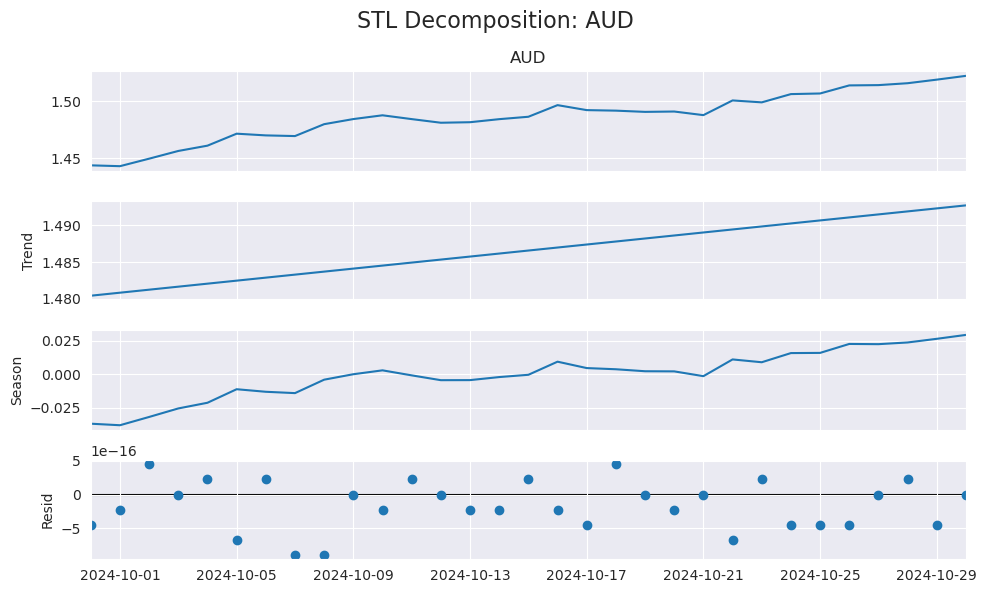


🔍 STL-декомпозиция: BRL


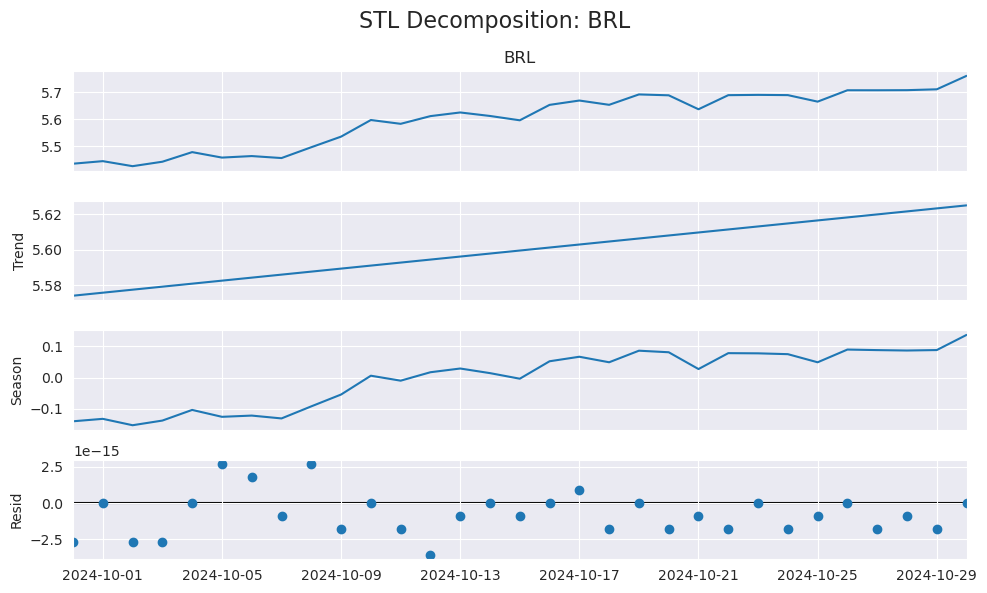


🔍 STL-декомпозиция: CAD


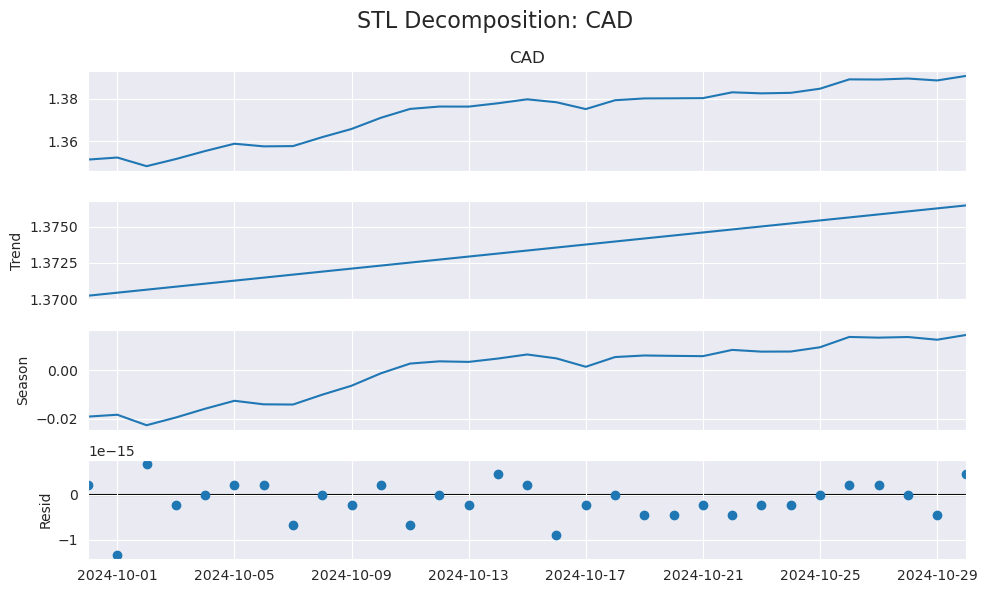


🔍 STL-декомпозиция: EUR


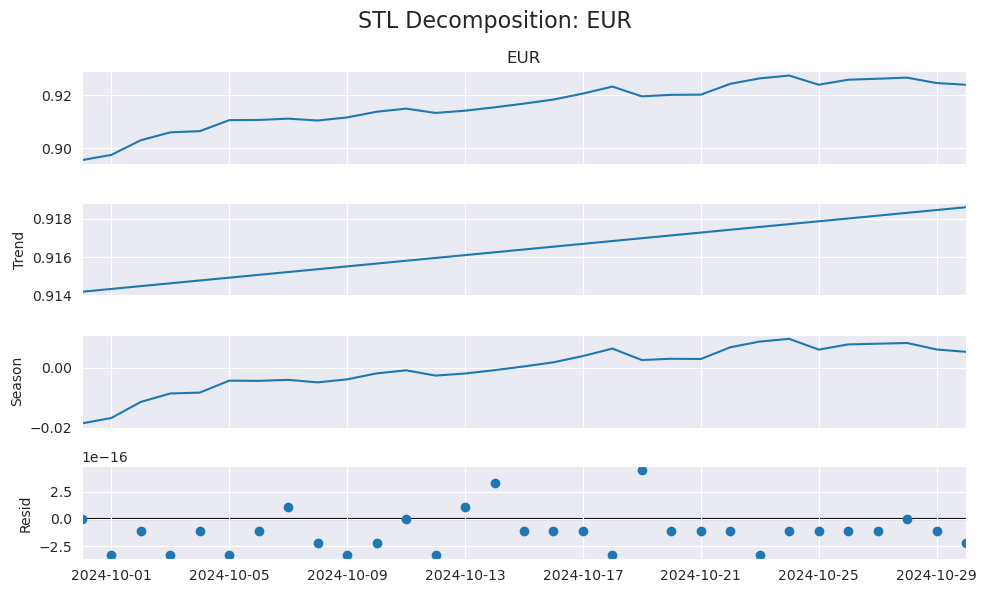


🔍 STL-декомпозиция: GBP


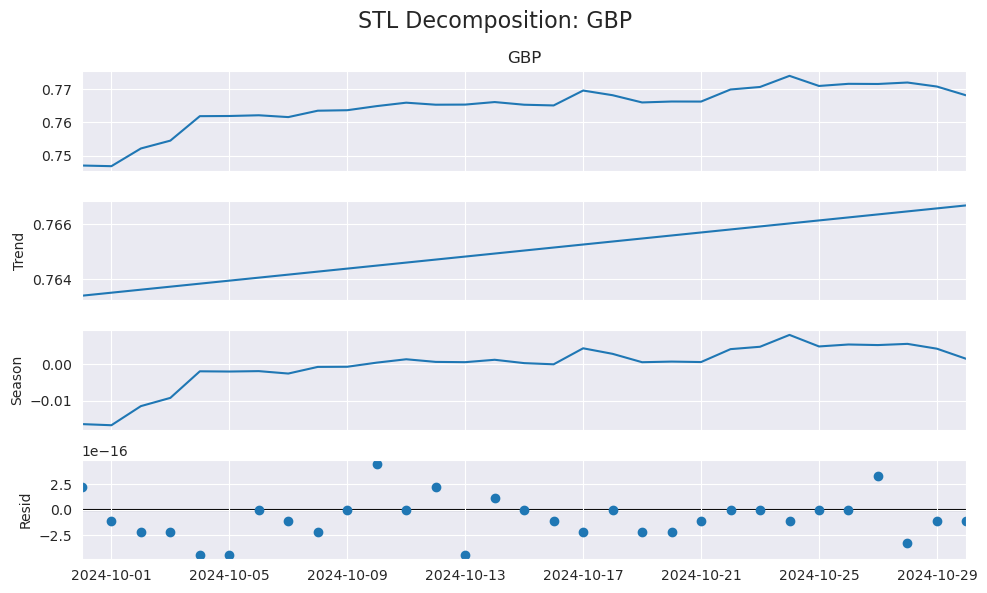


🔍 STL-декомпозиция: JPY


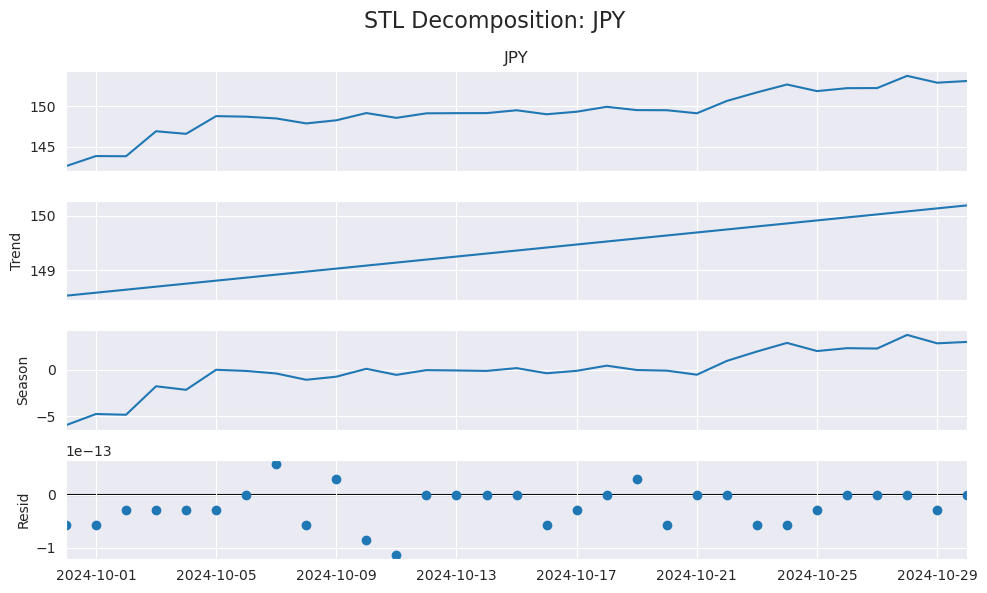


🔍 STL-декомпозиция: MXN


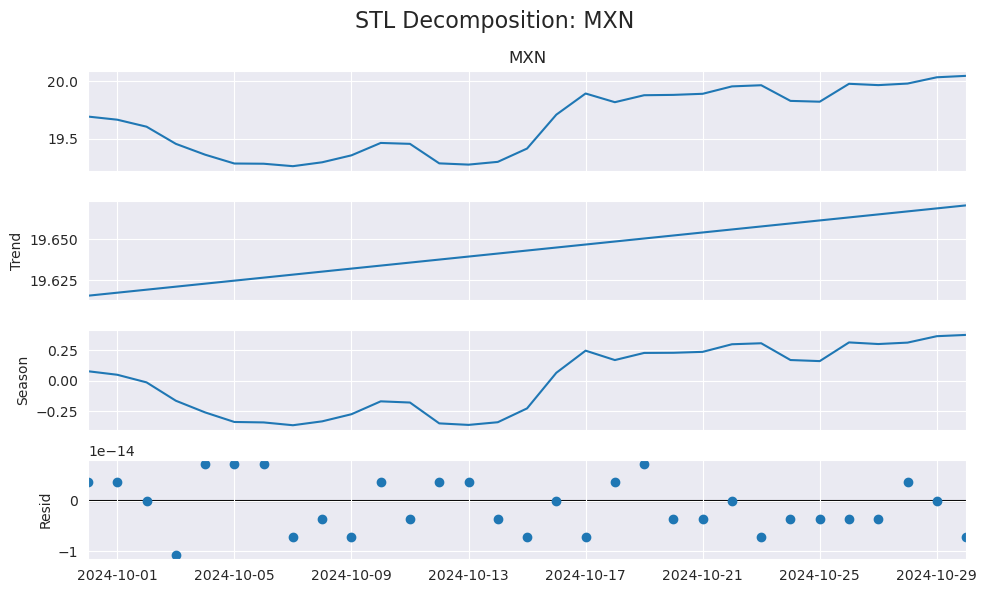


🔍 STL-декомпозиция: NGN


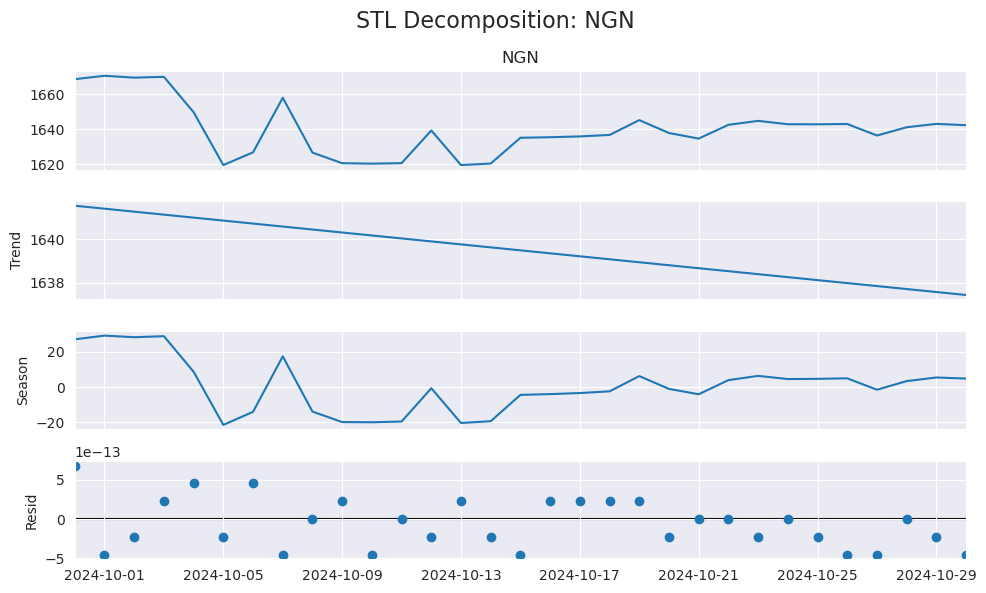


🔍 STL-декомпозиция: RUB


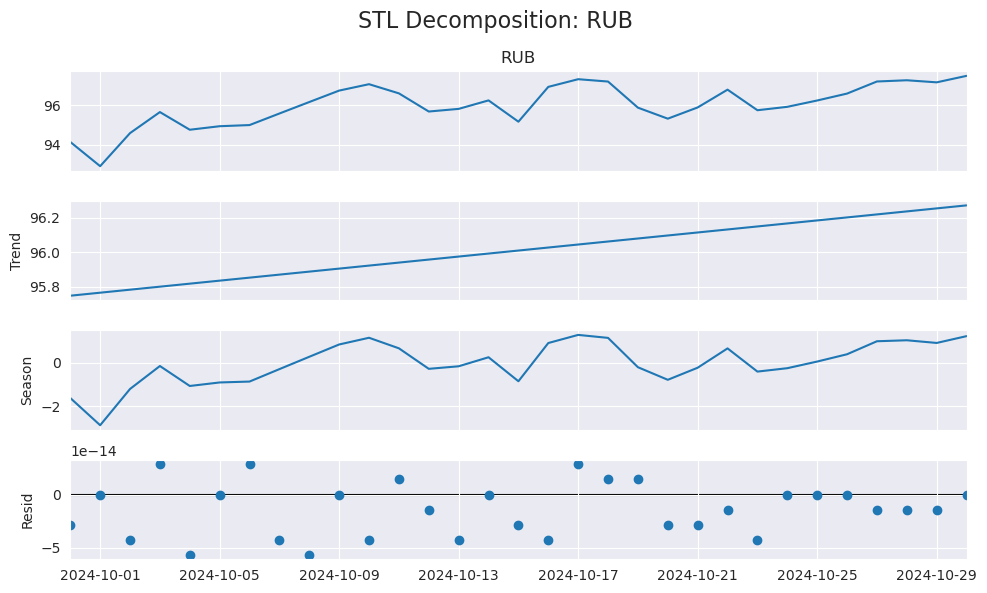


🔍 STL-декомпозиция: SGD


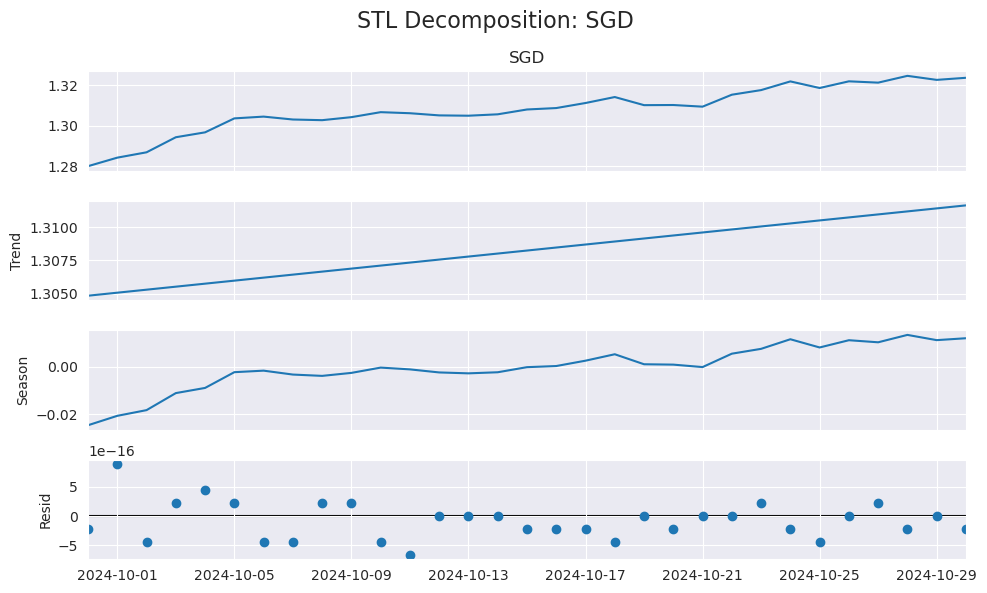


🔍 STL-декомпозиция: USD


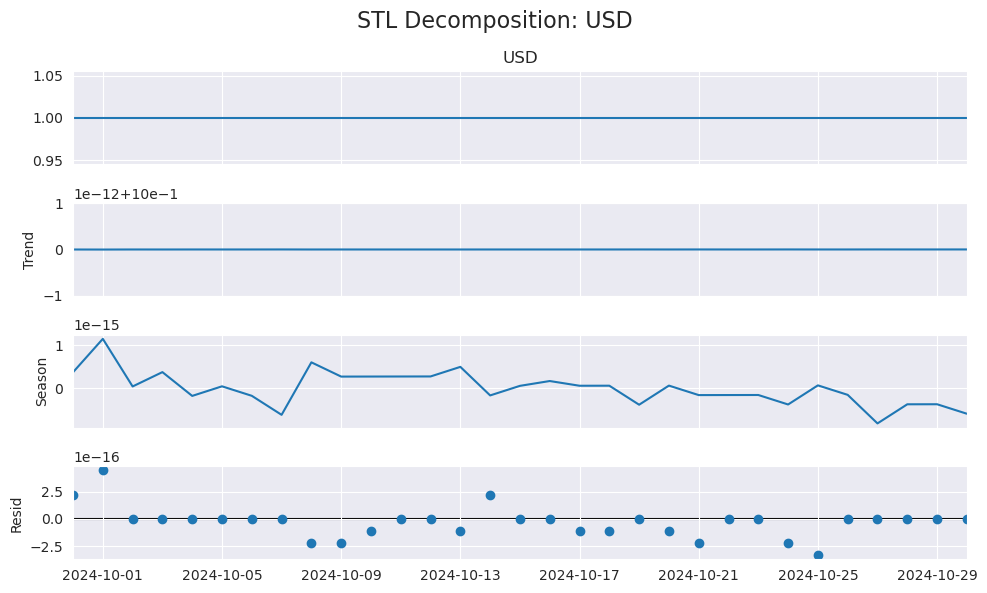

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

historic_ex_df_copy = historic_ex_df.copy()
historic_ex_df_copy['date'] = pd.to_datetime(historic_ex_df_copy['date'])
historic_ex_df_copy = historic_ex_df_copy.sort_values('date').set_index('date')

currency_columns = [col for col in historic_ex_df_copy.columns if historic_ex_df_copy[col].notna().sum() > 0]

for currency in currency_columns:
    print(f"\n🔍 STL-декомпозиция: {currency}")
    series = historic_ex_df_copy[currency].dropna()

    try:
        stl = STL(series, period=30)
        res = stl.fit()

        fig = res.plot()
        fig.set_size_inches(10, 6)
        fig.suptitle(f"STL Decomposition: {currency}", fontsize=16)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Проблема с '{currency}': {e}")


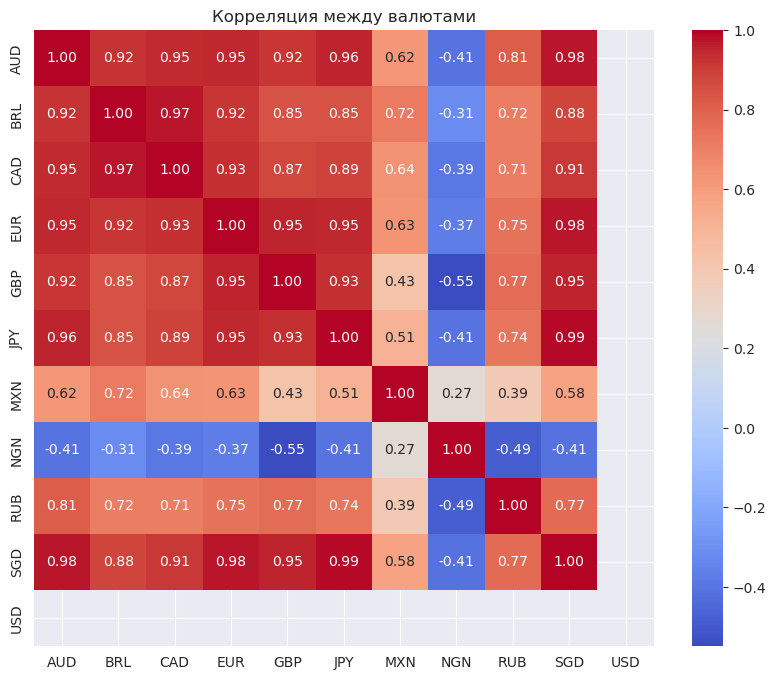

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = historic_ex_df_copy.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляция между валютами")
plt.show()


### Transactions

1 - Мошенические операции чаще аномально частые и по сумме разные (малые и частые, большие редкие) (last hour activity отражает частые подозритьельные операции за последний час до мошеничества)

2 - Мошенические операции чаще вне домашней страны

3 - Мошеничество одинаково часто в и вне категории is_high_risk_vendor

4 - Время дня в городе влияет на мошеничество

5 - Разные каналы - разная степень мошеничества

## EDA

In [8]:
transactions_df.columns

Index(['transaction_id', 'customer_id', 'card_number', 'timestamp',
       'vendor_category', 'vendor_type', 'vendor', 'amount', 'currency',
       'country', 'city', 'city_size', 'card_type', 'is_card_present',
       'device', 'channel', 'device_fingerprint', 'ip_address',
       'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend',
       'last_hour_activity', 'is_fraud'],
      dtype='object')

In [18]:
def get_rate(row):
    date = row['date']
    currency = row['currency'].upper()
    try:
        return historic_ex_df_s.at[date, currency]
    except KeyError:
        return np.nan

historic_ex_df_s = historic_ex_df.copy()
historic_ex_df_s['date'] = pd.to_datetime(historic_ex_df['date'])
historic_ex_df_s.set_index('date', inplace=True)

transactions_df['date'] = pd.to_datetime(transactions_df['timestamp']).dt.normalize()

transactions_df['rate_to_usd'] = transactions_df.apply(get_rate, axis=1)

transactions_df = transactions_df.dropna(subset=['rate_to_usd'])

transactions_df['amount_usd'] = transactions_df['amount'] / transactions_df['rate_to_usd']

transaction_df_copy = transactions_df.copy()

transaction_df_copy['num_transactions'] = transaction_df_copy['last_hour_activity'].apply(lambda x: x.get('num_transactions') if pd.notnull(x) else 0)
transaction_df_copy['total_amount_last_hour'] = transaction_df_copy['last_hour_activity'].apply(lambda x: x.get('total_amount') if pd.notnull(x) else 0)
transaction_df_copy['unique_merchants_last_hour'] = transaction_df_copy['last_hour_activity'].apply(lambda x: x.get('unique_merchants') if pd.notnull(x) else 0)
transaction_df_copy['unique_countries_last_hour'] = transaction_df_copy['last_hour_activity'].apply(lambda x: x.get('unique_countries') if pd.notnull(x) else 0)
transaction_df_copy['max_single_amount_last_hour'] = transaction_df_copy['last_hour_activity'].apply(lambda x: x.get('max_single_amount') if pd.notnull(x) else 0)


transaction_df_copy['timestamp'] = pd.to_datetime(transaction_df_copy['timestamp'])
transaction_df_copy['hour'] = transaction_df_copy['timestamp'].dt.hour
transaction_df_copy['weekday'] = transaction_df_copy['timestamp'].dt.dayofweek 
transaction_df_copy['is_weekend'] = transaction_df_copy['weekday'].isin([5,6]) 

print(transaction_df_copy.dtypes)
print(transaction_df_copy.isnull().sum())


transaction_id                         object
customer_id                            object
card_number                             int64
timestamp                      datetime64[us]
vendor_category                        object
vendor_type                            object
vendor                                 object
amount                                float64
currency                               object
country                                object
city                                   object
city_size                              object
card_type                              object
is_card_present                          bool
device                                 object
channel                                object
device_fingerprint                     object
ip_address                             object
is_outside_home_country                  bool
is_high_risk_vendor                      bool
is_weekend                               bool
last_hour_activity                

#### Stats and Visualizations


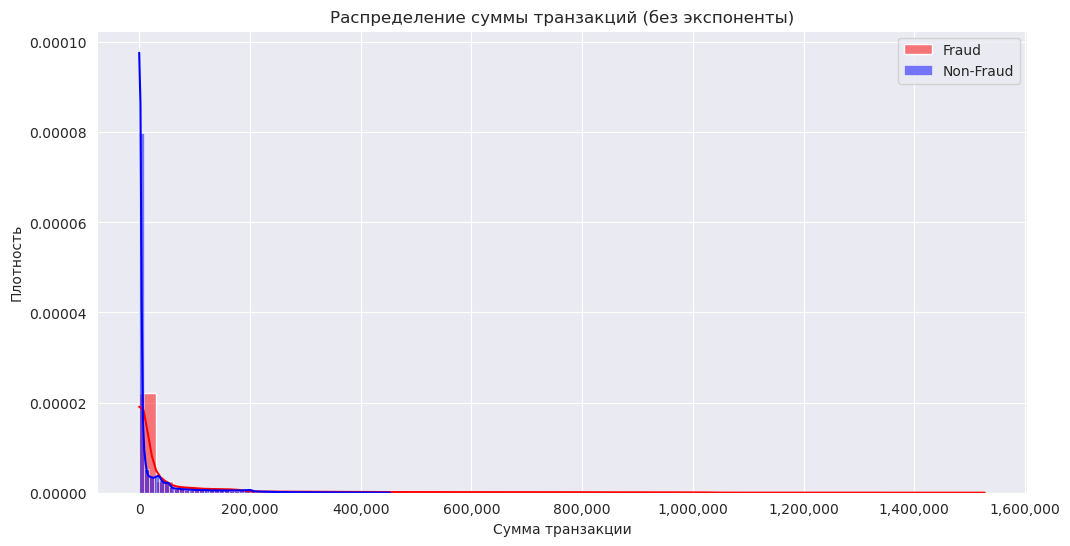

In [28]:
import matplotlib.ticker as ticker

fraud_df = transaction_df_copy[transaction_df_copy['is_fraud'] == True]
non_fraud_df = transaction_df_copy[transaction_df_copy['is_fraud'] == False]

plt.figure(figsize=(12, 6))

sns.histplot(fraud_cut['amount'], color='red', label='Fraud', kde=True, stat='density', bins=50)
sns.histplot(non_fraud_cut['amount'], color='blue', label='Non-Fraud', kde=True, stat='density', bins=50)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.title('Распределение суммы транзакций (без экспоненты)')
plt.xlabel('Сумма транзакции')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()


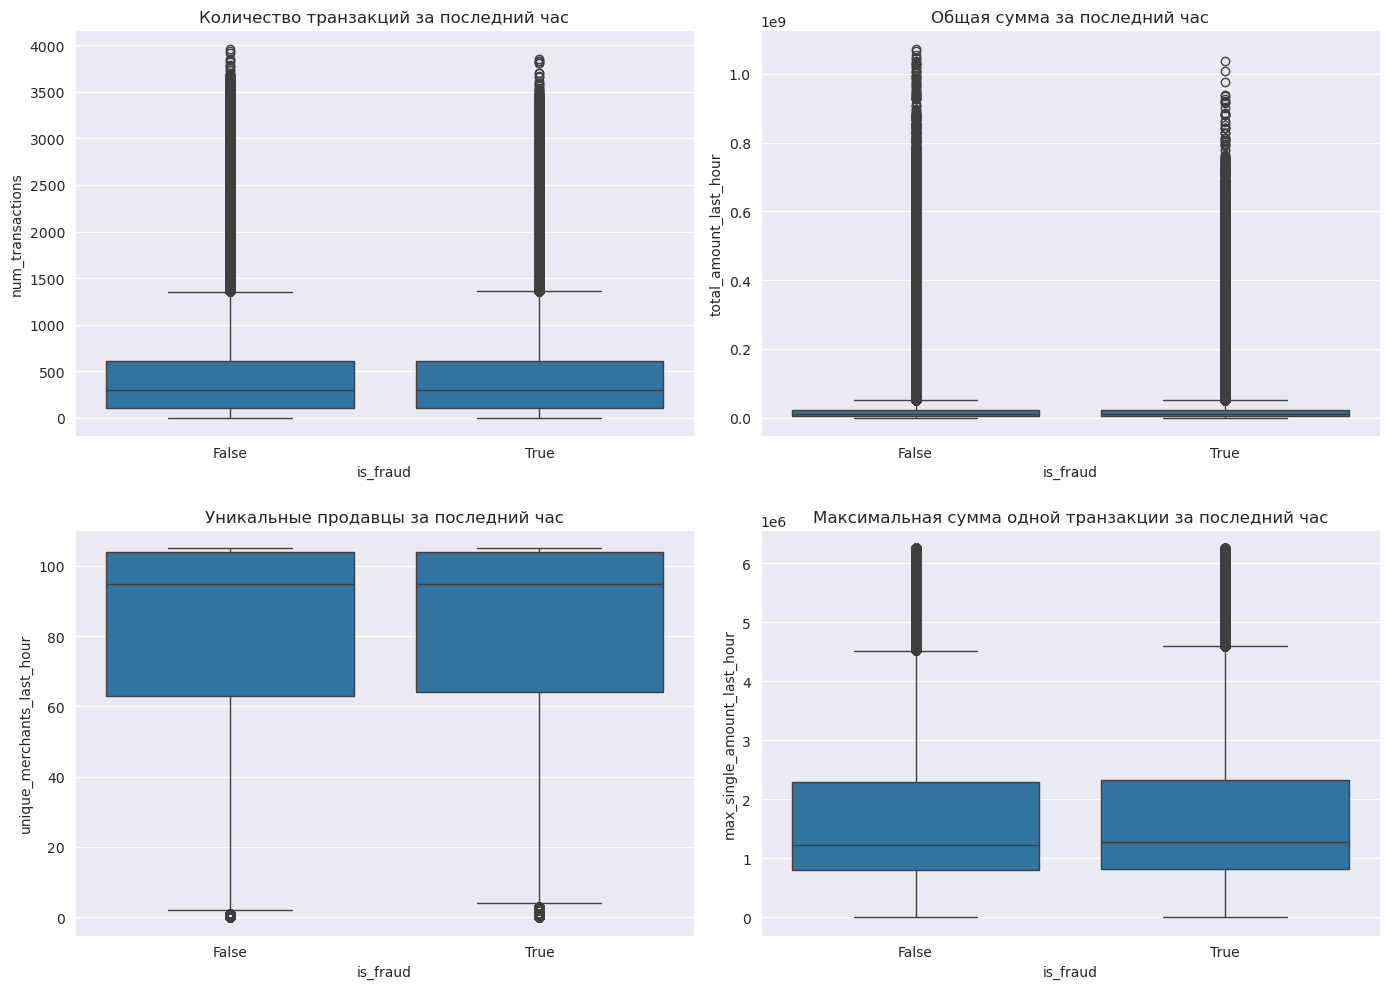

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))

sns.boxplot(x='is_fraud', y='num_transactions', data=transaction_df_copy, ax=axs[0,0])
sns.boxplot(x='is_fraud', y='total_amount_last_hour', data=transaction_df_copy, ax=axs[0,1])
sns.boxplot(x='is_fraud', y='unique_merchants_last_hour', data=transaction_df_copy, ax=axs[1,0])
sns.boxplot(x='is_fraud', y='max_single_amount_last_hour', data=transaction_df_copy, ax=axs[1,1])

axs[0,0].set_title('Количество транзакций за последний час')
axs[0,1].set_title('Общая сумма за последний час')
axs[1,0].set_title('Уникальные продавцы за последний час')
axs[1,1].set_title('Максимальная сумма одной транзакции за последний час')

plt.tight_layout()
plt.show()


### TimeSeries

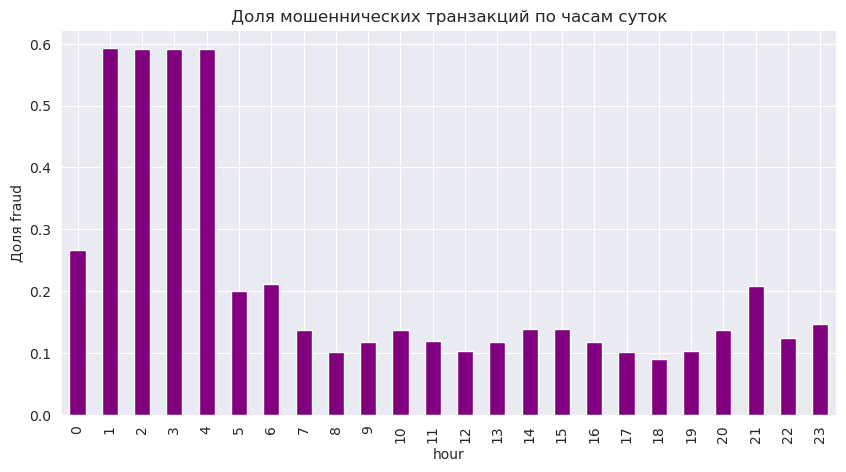

In [31]:
fraud_by_hour = transaction_df_copy.groupby('hour')['is_fraud'].mean()
plt.figure(figsize=(10,5))
fraud_by_hour.plot(kind='bar', color='purple')
plt.title('Доля мошеннических транзакций по часам суток')
plt.ylabel('Доля fraud')
plt.show()


In [33]:
fraud_weekend = transaction_df_copy.groupby('is_weekend')['is_fraud'].mean()
print(fraud_weekend)

is_weekend
False    0.199722
True     0.199746
Name: is_fraud, dtype: float64


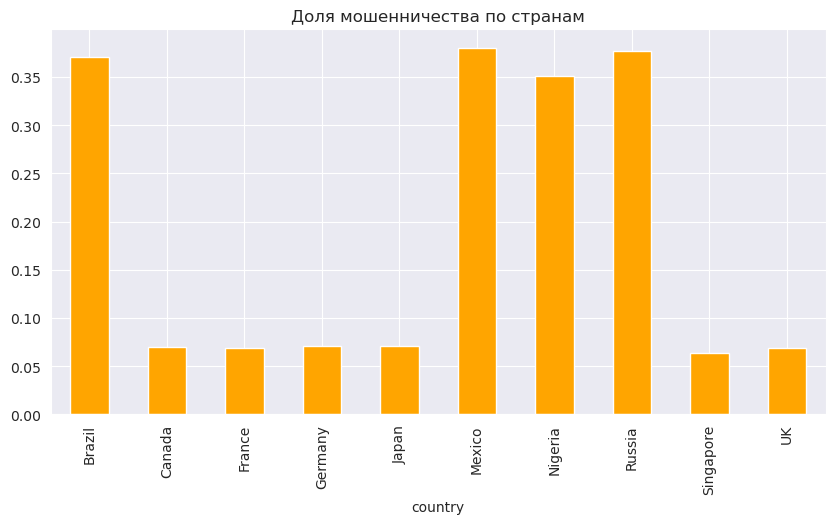

In [36]:
top_countries = transaction_df_copy['country'].value_counts().head(10).index
fraud_by_country = transaction_df_copy[transaction_df_copy['country'].isin(top_countries)].groupby('country')['is_fraud'].mean()
fraud_by_country.plot(kind='bar', color='orange', figsize=(10,5))
plt.title('Доля мошенничества по странам')
plt.show()

### Device analysis    

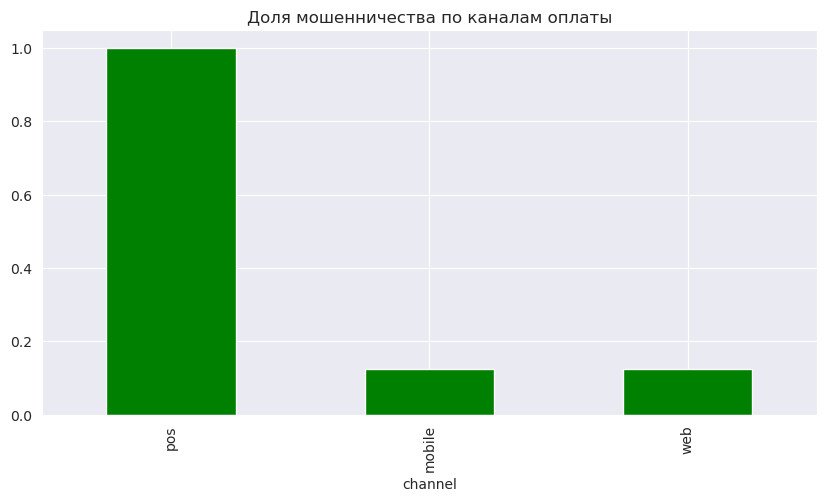

In [38]:
fraud_by_channel = transaction_df_copy.groupby('channel')['is_fraud'].mean().sort_values(ascending=False)
fraud_by_channel.plot(kind='bar', figsize=(10,5), color='green')
plt.title('Доля мошенничества по каналам оплаты')
plt.show()


In [39]:
print("Уникальных устройств у мошенников:", transaction_df_copy[transaction_df_copy['is_fraud']]['device_fingerprint'].nunique())
print("Уникальных устройств у нормальных:", transaction_df_copy[~transaction_df_copy['is_fraud']]['device_fingerprint'].nunique())

Уникальных устройств у мошенников: 775493
Уникальных устройств у нормальных: 9969


### Anomaly detection

In [41]:
fraud_customers = transaction_df_copy[transaction_df_copy['is_fraud']]['customer_id'].unique()
df_fraud_cust = transaction_df_copy[transaction_df_copy['customer_id'].isin(fraud_customers)]

rolling_num_trans = df_fraud_cust.groupby('customer_id').rolling(window=60, on='timestamp')['num_transactions'].mean().reset_index()


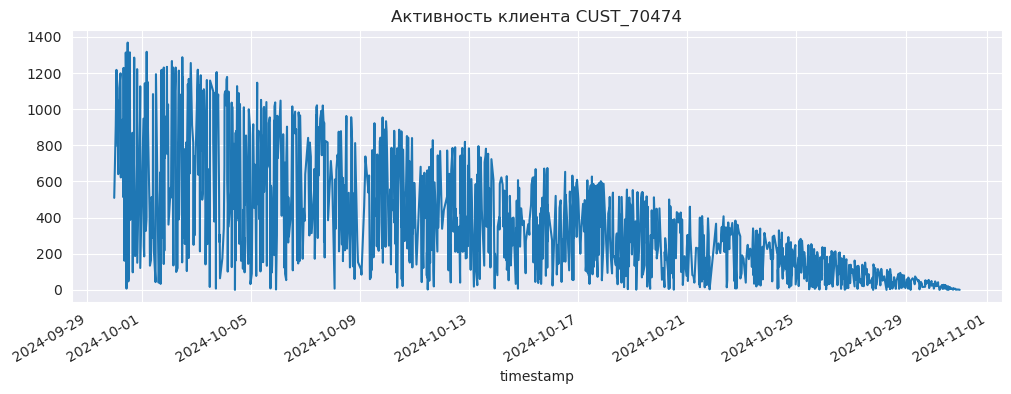

In [42]:
sample_cust = fraud_customers[0]
cust_data = transaction_df_copy[transaction_df_copy['customer_id'] == sample_cust].set_index('timestamp').sort_index()

cust_data['num_transactions'].plot(figsize=(12,4), title=f'Активность клиента {sample_cust}')
plt.show()


/tmp/ipykernel_28277/2085663037.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




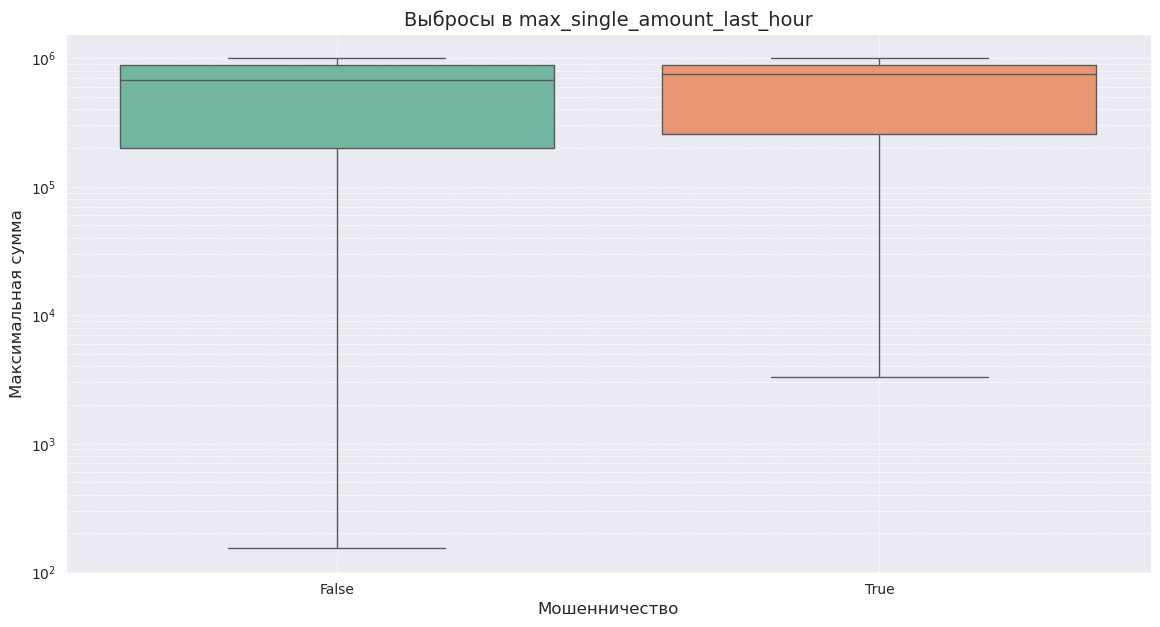

/tmp/ipykernel_28277/2085663037.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




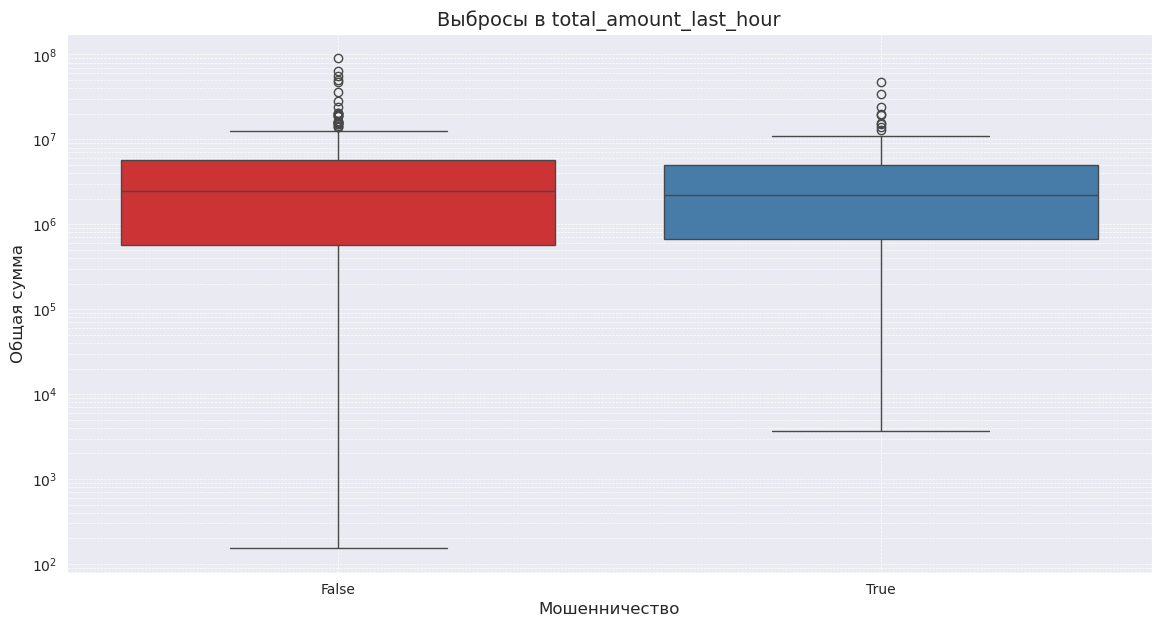

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sampled_df = transaction_df_copy.sample(n=1000, random_state=42)

filtered_df = sampled_df[
    (sampled_df['max_single_amount_last_hour'] > 0) &
    (sampled_df['max_single_amount_last_hour'] < 1_000_000) &
    (sampled_df['total_amount_last_hour'] > 0) 
    # (sampled_df['total_amount_last_hour'] < 1_000_000)
]

plt.figure(figsize=(14, 7))
sns.boxplot(
    data=filtered_df,
    x='is_fraud',
    y='max_single_amount_last_hour',
    palette='Set2'
)
plt.yscale('log')
plt.title('Выбросы в max_single_amount_last_hour', fontsize=14)
plt.xlabel('Мошенничество', fontsize=12)
plt.ylabel('Максимальная сумма', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(
    data=filtered_df,
    x='is_fraud',
    y='total_amount_last_hour',
    palette='Set1'
)
plt.yscale('log')
plt.title('Выбросы в total_amount_last_hour', fontsize=14)
plt.xlabel('Мошенничество', fontsize=12)
plt.ylabel('Общая сумма', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


In [55]:
transaction_df_copy['device']

0          iOS App
1             Edge
2          Firefox
3          iOS App
4           Chrome
            ...   
7483761     Safari
7483762     Chrome
7483763     Safari
7483764    Firefox
7483765     Chrome
Name: device, Length: 7483766, dtype: object

/tmp/ipykernel_56896/1626852737.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


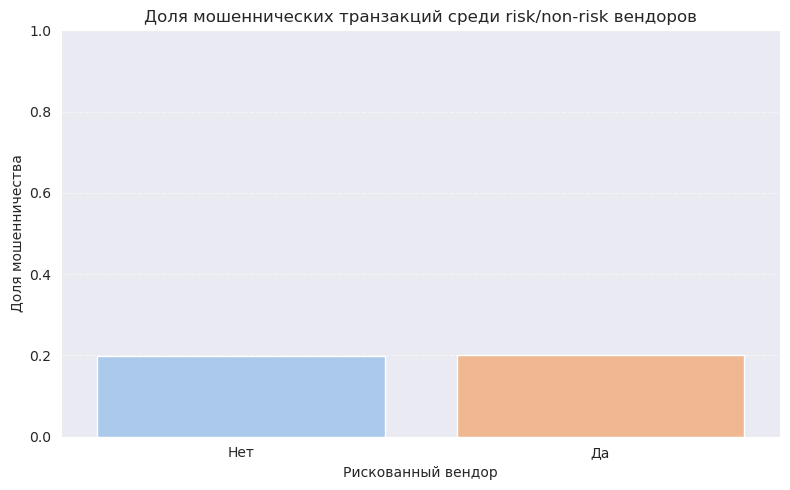

In [6]:
fraud_rate_by_risk = transactions_df.groupby('is_high_risk_vendor')['is_fraud'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=fraud_rate_by_risk,
    x='is_high_risk_vendor',
    y='is_fraud',
    palette='pastel'
)
plt.title('Доля мошеннических транзакций среди risk/non-risk вендоров')
plt.xlabel('Рискованный вендор')
plt.ylabel('Доля мошенничества')
plt.xticks([0, 1], ['Нет', 'Да'])
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

1 - гипотеза не подтвердилась, поведение мошенических и не мошенических операций одинаково в последний час одинаково, однако согласно расспределению, крайне дорогостоящие операции 

2 - зачастую, мошенические транзацкции не сильно отклоняются от средней для пользователя, то есть гипотеза не подтвердилась

3 - доля мошеничества выше ночью и зачастую происходит в Азии и в России

4 - чаще всего через Pos, Web, Mobile

5 - не подтвердилась